In [14]:
# para poder usar autosklearn mas adelante
!apt-get install swig -y
!pip install Cython numpy

!pip install dask >=2021.12
!pip install auto-sklearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,066 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 155653 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpa

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Llevamos el repositorio a nuestro drive

In [4]:
# Esto solo debemos ejecutarlo una vez. Si lo ejecutamos mas de una vez va a fallar (pero no pasa nada!)
!mkdir /content/gdrive/My\ Drive/ml-practico-code
# Acá podes usar tu propio repo si queres hacer modificaciones (highly recommended)
!git clone https://github.com/elsonidoq/ml-practico-2022 /content/gdrive/My\ Drive/ml-practico-code

mkdir: cannot create directory ‘/content/gdrive/My Drive/ml-practico-code’: File exists
fatal: destination path '/content/gdrive/My Drive/ml-practico-code' already exists and is not an empty directory.


In [2]:
# Si hay cambios en el repositorio, con esta linea actualizas tu drive
!cd /content/gdrive/My\ Drive/ml-practico-code; git pull

Already up to date.


In [2]:
import sys
sys.path.append('/content/gdrive/My Drive/ml-practico-code')

# Loading the data

In [3]:
SAMPLE = False # sirve para probar el codigo

In [4]:
from lib import transformers, data

In [5]:
from random import sample
from pathlib import Path

PATH = Path('/content/gdrive/My Drive/ml-practico-data')
movies = data.load_data(PATH)

if SAMPLE:
    movies = movies.sample(50000)

Loading title basics...


/content/gdrive/My Drive/ml-practico-code/lib/data.py:70: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  title_basics = load_title_basics(path)


Loading title ratings...
Loading movie directors...
Merging everything...


# Model helpers

In [6]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.feature_extraction import DictVectorizer

def get_features_pipe(
        use_years: bool, use_genre: bool, 
        use_director: bool, director_kws: dict=None, post_processing=None):
    """
    Construye el pipeline de features de forma parametrizada
    """
    # director_kws solo tiene sentido cuando use_director=True. 
    # Esto nos va a traer dolores de cabeza a la hora de explorar el espacio de hyper parametros
    # TODO: esto debería permitir cachear los datasets transformados
    
    steps = []
    if use_years:
        steps.append(make_pipeline(transformers.YearsAgo(), DictVectorizer(sparse=False)))
    
    if use_genre:
        steps.append(make_pipeline(transformers.GenreDummies(), DictVectorizer(sparse=False)))
        
    if use_director:
        director_kws = director_kws or {}
        # cuando hacemos **director_kws usamos ese diccionario para pasar parametros
        steps.append(make_pipeline(transformers.DirectorFeatures(**director_kws), DictVectorizer(sparse=False)))
    
    res = make_union(*steps)
    if post_processing:
        res = make_pipeline(res, post_processing)
    return res

def get_model_pipe(features_pipe, estimator):
    return make_pipeline(features_pipe, estimator)

In [9]:
from sklearn.metrics import fbeta_score, roc_auc_score

def get_metrics(model, X, y, threshold=0.5):
    scores = model.predict_proba(X)[:, 1]
    return {
        'f_0.5': fbeta_score(y, scores > threshold, beta=0.5),
        'roc_auc': roc_auc_score(y, scores)
    }

# Modelado sencillo

Para ejemplificar el model selection. La proxima clase iteramos sobre esto

1. Modelamos el problema como clasificacion P(rating > 7.5)
2. Evaluamos con f_beta score, con beta = 0.5

![image.png](attachment:image.png)

In [7]:
train_df = movies[movies.startYear <= 2015]
dev_df = movies[(movies.startYear > 2015) & (movies.startYear <= 2017)]
test_df = movies[movies.startYear > 2017]

# Esto es lentisimo, hay que evitar en proyectos grandes levantar cosas en pandas
# Si luego vamos a hacer algun pipeline de Machine Learning
X_train = train_df.to_dict(orient='records')
X_dev = dev_df.to_dict(orient='records')
X_test = test_df.to_dict(orient='records')

len(train_df), len(dev_df), len(test_df), len(test_df) / len(train_df), len(dev_df) / len(train_df)

(264315, 21687, 39839, 0.15072546015171293, 0.08204982691107202)

In [8]:
y_train = (train_df.averageRating > 7.5).values
y_dev = (dev_df.averageRating > 7.5).values
y_test = (test_df.averageRating > 7.5).values

y_train.sum() / len(y_train), y_dev.sum() / len(y_dev), y_test.sum() / len(y_test)

(0.14616272250912737, 0.17761792779084243, 0.17753959687743165)

## Ejemplo de uso

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

model = get_model_pipe(
    features_pipe=get_features_pipe(
        use_years=False, use_director=True, use_genre=True, post_processing=StandardScaler()
    ),
    estimator=LogisticRegression()   
)

model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('featureunion',
                                  FeatureUnion(transformer_list=[('pipeline-1',
                                                                  Pipeline(steps=[('genredummies',
                                                                                   GenreDummies()),
                                                                                  ('dictvectorizer',
                                                                                   DictVectorizer(sparse=False))])),
                                                                 ('pipeline-2',
                                                                  Pipeline(steps=[('directorfeatures',
                                                                                   DirectorFeatures()),
                                                                                  ('dictvectorizer',
                                    

In [15]:
model.fit(X_train, y_train);

In [16]:
y_pred_train = model.predict_proba(X_train)[: , 1]
y_pred_train[:10]

array([0.0358808 , 0.08644033, 0.11116386, 0.0850014 , 0.01697863,
       0.07380756, 0.27186813, 0.03479678, 0.07781627, 0.14517975])

In [17]:
# Para jugar: como cambia la metrica cuando tocamos el threshold y beta?
# Se mueve como esperamos que se mueva?

fbeta_score(y_train, y_pred_train > 0.5, beta=0.5)

0.4892500172670673

In [18]:
get_metrics(model, X_train, y_train)

{'f_0.5': 0.4892500172670673, 'roc_auc': 0.8332075894122982}

In [19]:
get_metrics(model, X_dev, y_dev)

{'f_0.5': 0.21033314511575382, 'roc_auc': 0.7306690628674468}

Parece haber un roc auc relativamente bueno, sin embargo el f_0.5 da super bajo.

### Para pensar 🤔
Cómo podríamos optimizar el f_0.5 cambiando el threshold?

# Grid search

In [20]:
from time import time
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def experiment_lr(model_params, feature_params, X_train, y_train, X_dev, y_dev):
    # Resolvemos el tema del director
    feature_params['use_director'] = feature_params['director_kws'] is not None
    
    model = get_model_pipe(
        features_pipe=get_features_pipe(**feature_params),
        estimator=LogisticRegression(**model_params)
    )
    
    t0 = time()
    model.fit(X_train, y_train)
    elapsed = time() - t0
    
    return {
        'model': model,
        'train_metrics': get_metrics(model, X_train, y_train),
        'dev_metrics': get_metrics(model, X_dev, y_dev),
        'params': {
            'model': model_params, 'feature': feature_params
        }
    }

In [21]:
from sklearn.model_selection import ParameterGrid

lr_grid = ParameterGrid(
    {
        'penalty': ['l1', 'l2'],
#         'tol': [1e-4, 1e-5, 1e-3],
        'C': [10.0, 1.0, 0.1],
        'class_weight': ['balanced', None],
        'solver': ['saga'],
    }
)

feature_grid = ParameterGrid(
    {
        'use_years': [True], 
        'use_genre': [True],  
        # Tenemos 2 hyper parametros interdependientes, solo seteamos director_kws
        'director_kws': [None, dict(min_cnt_movies=0), dict(min_cnt_movies=3)],
        'post_processing': [StandardScaler()] # siempre hacemos esto porque es regresion logistica
    }
)

In [22]:
from tqdm.notebook import tqdm

def run_lr_experiments(): 
    # No toma parametros porque usa las variables globales que definimos durante el notebook
    
    results = []
    for model_params in tqdm(list(lr_grid)):
        for feature_params in feature_grid:
            empty_features = (
                not feature_params['use_years'] and 
                not feature_params['use_genre'] and 
                feature_params['director_kws'] is None
            )
            if empty_features: continue  # esta combinacion no tiene sentido probarla porque no usa ningun feature

            results.append(experiment_lr(model_params, feature_params, X_train, y_train, X_test, y_test))
    
    return results

In [23]:
experiment_outputs = run_lr_experiments()

  0%|          | 0/12 [00:00<?, ?it/s]

In [24]:
import pandas as pd

experiment_outputs_flat = []
for e_nested in experiment_outputs:
    e_flat = {
        'train_auc': e_nested['train_metrics']['roc_auc'],
        'dev_auc': e_nested['dev_metrics']['roc_auc'],
    }
    e_flat.update(e_nested['params']['model'])
    e_flat.update(e_nested['params']['feature'])
    experiment_outputs_flat.append(e_flat)
    
experiments_df = pd.DataFrame(experiment_outputs_flat).drop('post_processing', axis=1)

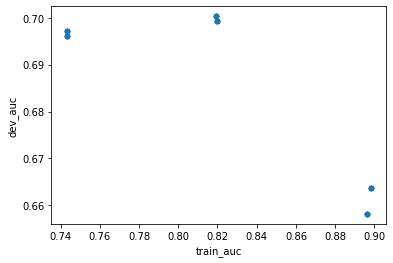

In [25]:
experiments_df.plot.scatter('train_auc', 'dev_auc')

In [26]:
experiments_df.sort_values('train_auc', ascending=False)

,train_auc,dev_auc,C,class_weight,penalty,solver,director_kws,use_genre,use_years,use_director
16,0.898226,0.663686,1.0,balanced,l2,saga,{'min_cnt_movies': 0},True,True,True
1,0.898226,0.663685,10.0,balanced,l1,saga,{'min_cnt_movies': 0},True,True,True
4,0.898226,0.663686,10.0,balanced,l2,saga,{'min_cnt_movies': 0},True,True,True
28,0.898226,0.663690,0.1,balanced,l2,saga,{'min_cnt_movies': 0},True,True,True
13,0.898226,0.663687,1.0,balanced,l1,saga,{'min_cnt_movies': 0},True,True,True
25,0.898222,0.663683,0.1,balanced,l1,saga,{'min_cnt_movies': 0},True,True,True
34,0.896112,0.658210,0.1,None,l2,saga,{'min_cnt_movies': 0},True,True,True
22,0.896100,0.658192,1.0,None,l2,saga,{'min_cnt_movies': 0},True,True,True
10,0.896099,0.658188,10.0,None,l2,saga,{'min_cnt_movies': 0},True,True,True
7,0.896098,0.658187,10.0,None,l1,saga,{'min_cnt_movies': 0},True,True,True


In [27]:
best = max(experiment_outputs, key=lambda x: x['dev_metrics']['roc_auc'])

In [28]:
best

{'dev_metrics': {'f_0.5': 0.18490109002826, 'roc_auc': 0.7003236057480591},
 'model': Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('featureunion',
                                   FeatureUnion(transformer_list=[('pipeline-1',
                                                                   Pipeline(steps=[('yearsago',
                                                                                    YearsAgo()),
                                                                                   ('dictvectorizer',
                                                                                    DictVectorizer(sparse=False))])),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('genredummies',
                                                                                    GenreDummies()),
                                                          

### Para pensar 🤔

Usando este código de base, como implementarías random search?

# Hyperopt: Sequential Model Based Optimization

https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

In [29]:
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import numpy as np
from hyperopt import hp

lr_space = {
    'model_params': {
            'penalty': hp.choice('penalty', ['l1', 'l2']),
            'C': hp.loguniform('C', np.log(0.001), np.log(100)),
            'class_weight': hp.choice('class_weight', ['balanced', None]),
            'solver': 'saga',
        },
    
    'feature_params': {
        'use_years': hp.choice('use_years', [True, False]),
        'use_genre': hp.choice('use_genre', [True, False]), 
        # Tenemos 2 hyper parametros interdependientes, solo seteamos director_kws
        'director_kws': hp.choice('director_kws', 
                    [None, dict(min_cnt_movies=0), 
                     dict(min_cnt_movies=1), dict(min_cnt_movies=2), dict(min_cnt_movies=3),
                     dict(min_cnt_movies=6), dict(min_cnt_movies=8), dict(min_cnt_movies=10)
                    ]
        ),
        'post_processing': StandardScaler() # siempre hacemos esto porque es regresion logistica
    }
}

In [31]:
import pickle
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, STATUS_FAIL

def objective(x):
    feature_params = x['feature_params']
    model_params = x['model_params']
    
    empty_features = (
        not feature_params['use_years'] and 
        not feature_params['use_genre'] and 
        feature_params['director_kws'] is None
    )
    if empty_features:   
        # esta combinacion no tiene sentido probarla porque no usa ningun feature
        # misma cosa que en el grid search
        return {'loss': 1000, 'status': STATUS_FAIL}

    exp_output = experiment_lr(model_params, feature_params, X_train, y_train, X_test, y_test)
    exp_output['loss'] = -exp_output['dev_metrics']['roc_auc']
    exp_output['status'] = STATUS_OK
    return exp_output

trials = Trials()
fmin(
    objective,
    space=lr_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
);

100%|██████████| 100/100 [29:27<00:00, 17.68s/it, best loss: -0.7018982759980783]


In [32]:
trials.best_trial

{'book_time': datetime.datetime(2022, 7, 14, 17, 10, 8, 681000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'C': [88],
   'class_weight': [88],
   'director_kws': [88],
   'penalty': [88],
   'use_genre': [88],
   'use_years': [88]},
  'tid': 88,
  'vals': {'C': [0.3423006078037341],
   'class_weight': [1],
   'director_kws': [5],
   'penalty': [0],
   'use_genre': [0],
   'use_years': [0]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2022, 7, 14, 17, 10, 31, 463000),
 'result': {'dev_metrics': {'f_0.5': 0.15090448964289063,
   'roc_auc': 0.7018982759980783},
  'loss': -0.7018982759980783,
  'model': Pipeline(steps=[('pipeline',
                   Pipeline(steps=[('featureunion',
                                    FeatureUnion(transformer_list=[('pipeline-1',
                                                                    Pipeline(steps=[('yearsago',
                                                            

## Para pensar 🤔

* Cómo se adaptaría todo esto para usar GradientBoostingClassifier, o lightgbm?
* Qué pasa promediáramos la mejor regresion logística con el mejor arbol? Mejoraría?
* Valdría la pena esa ganancia en performance para el problema que queremos resolver? Al principio del proyecto? 1 año despues de que arranco? Nunca?

* Si hiciste algun feature transformer extra? Cómo evaluarías si ese transformer mejora?

# Auto sklearn

In [12]:
import autosklearn.classification
from autosklearn.metrics import roc_auc
from sklearn.preprocessing import StandardScaler

model = get_model_pipe(
    features_pipe=get_features_pipe(
        use_years=False, use_director=True, use_genre=True, post_processing=StandardScaler()
    ),
    estimator=autosklearn.classification.AutoSklearnClassifier(metric=roc_auc)
)


model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('featureunion',
                                  FeatureUnion(transformer_list=[('pipeline-1',
                                                                  Pipeline(steps=[('genredummies',
                                                                                   GenreDummies()),
                                                                                  ('dictvectorizer',
                                                                                   DictVectorizer(sparse=False))])),
                                                                 ('pipeline-2',
                                                                  Pipeline(steps=[('directorfeatures',
                                                                                   DirectorFeatures()),
                                                                                  ('dictvectorizer',
                                    

In [13]:
get_metrics(model, X_train, y_train)

{'f_0.5': 0.5375594491177519, 'roc_auc': 0.8898933645397866}

In [14]:
get_metrics(model, X_dev, y_dev)

{'f_0.5': 0.40397239521966, 'roc_auc': 0.7359210322149413}

## Ojo! 👀

AutoSklearnClassifier usa modelos no lineales y lo de arriba esta todo hecho con una regresion logística!